# Collect Data from AWS Comprehend

Data is a concatenated title and review

In [222]:
import pandas as pd
# !mkdir Data
# !rm -rf Data/train.csv
# !aws s3 cp s3://phdata-nlp-s3-bucket/comprehend-input/sample_neg_reviews.csv  Data/
# !wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz 
# !tar -xvzf amazon_review_polarity_csv.tgz
# !rm -rf  amazon_review_polarity_csv
# !mkdir -p Data/
# !cp amazon_review_polarity_csv/train.csv Data/
df = pd.read_csv("Data/sample_neg_reviews.csv", usecols=["title_and_review"],header=0)

In [223]:
df[:10]

,title_and_review
0,Umm....Get a life....a REAL one This is corny....
1,Yukkk! Please don't think this is really Dean ...
2,A Disapointment Unfortunately this pump has be...
3,¿little Goldie influence? What happened with t...
4,It really didn't work as described I was surpr...
5,the DVD was damaged and won't play We saw a po...
6,Awful I struggled to read Easy last summer and...
7,Is it only me ? I have read a few books on sto...
8,Skeeter is Jar Jar Binks Rabbit Redux is by fa...
9,Not the kind of DVD Heroes del Silencio deserv...


In [224]:
df.count()

title_and_review    360000
dtype: int64

In [104]:
!aws s3 cp s3://phdata-nlp-s3-bucket/comprehend-output/output.tar.gz output/.
!tar -xvzf output/output.tar.gz

download: s3://phdata-nlp-s3-bucket/comprehend-output/output.tar.gz to output/output.tar.gz
topic-terms.csv
doc-topics.csv


Comprehend outputs two files, one is doc relation to topic. Second one is topics relation to terms.

In [105]:
df_doc_terms = pd.read_csv("doc-topics.csv")
df_top_terms=pd.read_csv("topic-terms.csv")

In [174]:
df_doc_terms[:10]

,docname,topic,proportion,ranks
0,sample_neg_reviews.csv:6,1,1.000000,1
1,sample_neg_reviews.csv:41,0,1.000000,1
3,sample_neg_reviews.csv:76,4,0.321274,1
4,sample_neg_reviews.csv:111,2,1.000000,1
5,sample_neg_reviews.csv:146,4,1.000000,1
6,sample_neg_reviews.csv:181,0,1.000000,1
7,sample_neg_reviews.csv:216,2,1.000000,1
8,sample_neg_reviews.csv:251,1,1.000000,1
9,sample_neg_reviews.csv:286,4,1.000000,1
11,sample_neg_reviews.csv:321,0,0.273555,1


In [128]:
df_top_terms[df_top_terms['topic']== 3]

,topic,term,weight
30,3,money,0.051282
31,3,waste,0.049537
32,3,time,0.033459
33,3,buy,0.027023
34,3,save,0.011075
35,3,worth,0.011764
36,3,spend,0.006934
37,3,complete,0.003891
38,3,junk,0.004677
39,3,piece,0.004807


# Mapping Reviews to Topics

In [119]:
df_doc_terms['ranks']=df_doc_terms.groupby(by=['docname'])['proportion'].rank(method="first", ascending=True)
df_doc_terms["ranks"] = df_doc_terms['ranks'].astype(int)
df_doc_terms=df_doc_terms[df_doc_terms['ranks']==1]

In [225]:
import numpy as np

# map_reviews= ['bad read','review','quality','operational','media','movie','music','battery life','order-related','enterntainment']
map_reviews=['book summary','order related','product issue','unsatisfied','media']
dict_l={}
l=[]

for index, row in df_doc_terms.iterrows():
    index_pos=int(row['docname'].split(":")[1]) 
    topic_no=int(row['topic'])
    map_revews_colname=map_reviews[topic_no]
    dict_l[index_pos]=map_revews_colname

# Adding this delte as the comprehend scored dataset with the header row
del(dict_l[0])

col_label=[]
for key, value in sorted(dict_l.items(), key=lambda item: item[0]):
    col_label.append(str(value))
    
df['topic']=pd.Series(col_label)

In [211]:
df=df.sort_index

In [227]:
df[:10]

,title_and_review,topic
0,Umm....Get a life....a REAL one This is corny....,unsatisfied
1,Yukkk! Please don't think this is really Dean ...,book summary
2,A Disapointment Unfortunately this pump has be...,product issue
3,¿little Goldie influence? What happened with t...,media
4,It really didn't work as described I was surpr...,product issue
5,the DVD was damaged and won't play We saw a po...,order related
6,Awful I struggled to read Easy last summer and...,book summary
7,Is it only me ? I have read a few books on sto...,book summary
8,Skeeter is Jar Jar Binks Rabbit Redux is by fa...,book summary
9,Not the kind of DVD Heroes del Silencio deserv...,media


In [228]:
df['title_and_review'] = "__label__"+df['topic'].astype(str) + " "+ df['title_and_review'].astype(str)

In [230]:
df[:10]

,title_and_review,topic
0,__label__unsatisfied Umm....Get a life....a RE...,unsatisfied
1,__label__book summary Yukkk! Please don't thin...,book summary
2,__label__product issue A Disapointment Unfortu...,product issue
3,__label__media ¿little Goldie influence? What ...,media
4,__label__product issue It really didn't work a...,product issue
5,__label__order related the DVD was damaged and...,order related
6,__label__book summary Awful I struggled to rea...,book summary
7,__label__book summary Is it only me ? I have r...,book summary
8,__label__book summary Skeeter is Jar Jar Binks...,book summary
9,__label__media Not the kind of DVD Heroes del ...,media


In [231]:
!rm Data/labelled_reviews_short.csv
df.to_csv(r'Data/labelled_reviews_short.csv')

In [232]:
!aws s3 cp Data/labelled_reviews_short.csv s3://phdata-nlp-s3-bucket/

upload: Data/labelled_reviews_short.csv to s3://phdata-nlp-s3-bucket/labelled_reviews_short.csv


In [125]:
df_topic_counts=df.groupby(['topic']).size().reset_index(name='counts')
df_topic_counts=df_topic_counts.sort_values(by='counts',ascending=False)

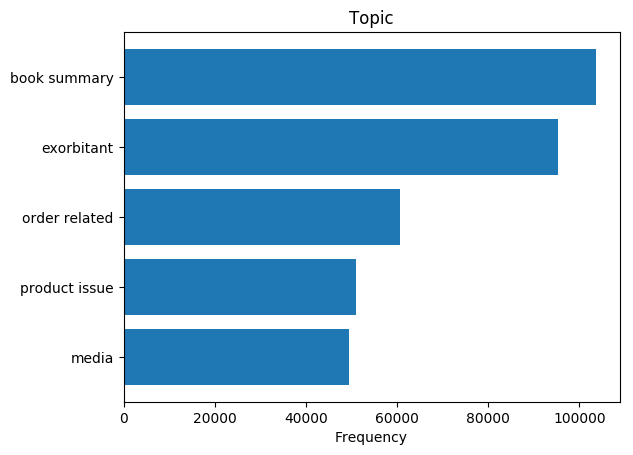

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(5)
performance = df_topic_counts['counts']

ax.barh(df_topic_counts['topic'], performance, align='center')
ax.set_yticks(y_pos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Topic')

plt.show()